In [ ]:
pip install transformers torch

Note: you may need to restart the kernel to use updated packages.


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
#from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from bs4 import BeautifulSoup
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from spacy.lang.en import English
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup

In [4]:
data=pd.read_csv("IMDB Dataset.csv")

In [5]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
rows=len(data.axes[0])
rows

50000

In [7]:
cols=len(data.axes[1])
cols

2

In [8]:
data.isnull().sum()

,0
review,0
sentiment,0


In [9]:
print(data['sentiment'].value_counts())

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [10]:
print(len(data['review'].unique()))

49582


In [11]:
# Show summary statistics of the text length and sentiment distribution
data['review_length'] = data['review'].apply(len)
print(data[['review_length', 'sentiment']].describe())

       review_length
count   50000.000000
mean     1309.431020
std       989.728014
min        32.000000
25%       699.000000
50%       970.000000
75%      1590.250000
max     13704.000000


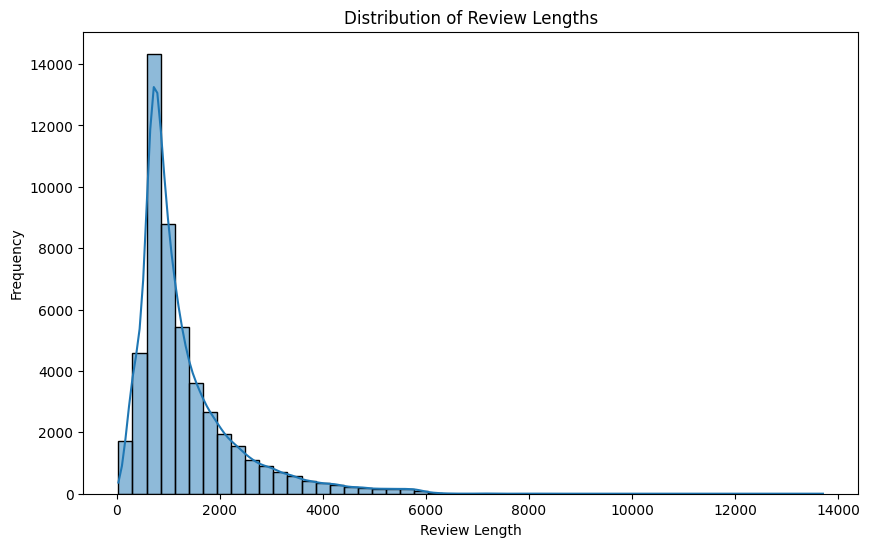

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(data['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

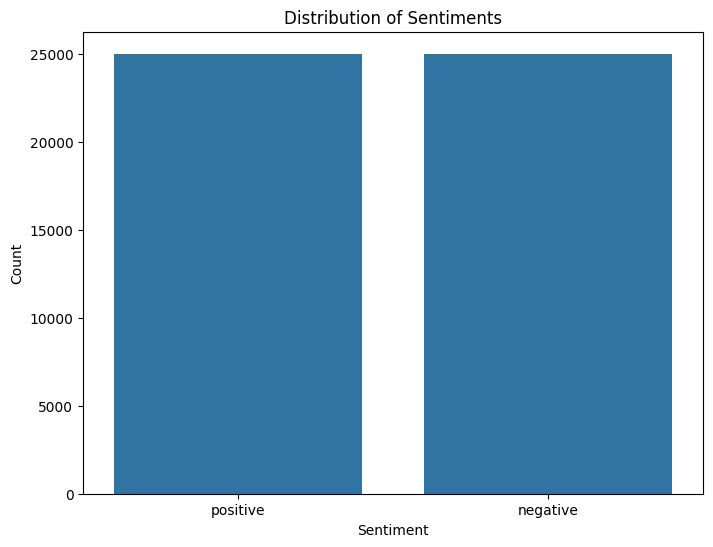

In [13]:
# Plot the distribution of sentiments
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=data)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

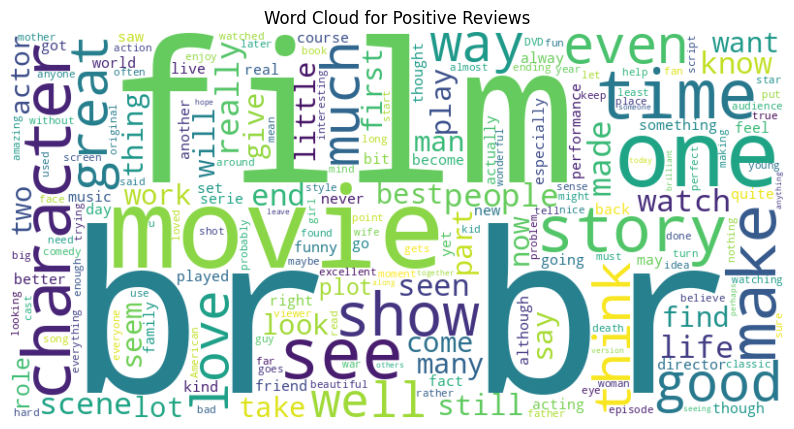

In [14]:
# Display a word cloud for positive reviews
from wordcloud import WordCloud

positive_reviews = data[data['sentiment'] == 'positive']['review']
positive_text = ' '.join(positive_reviews)

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

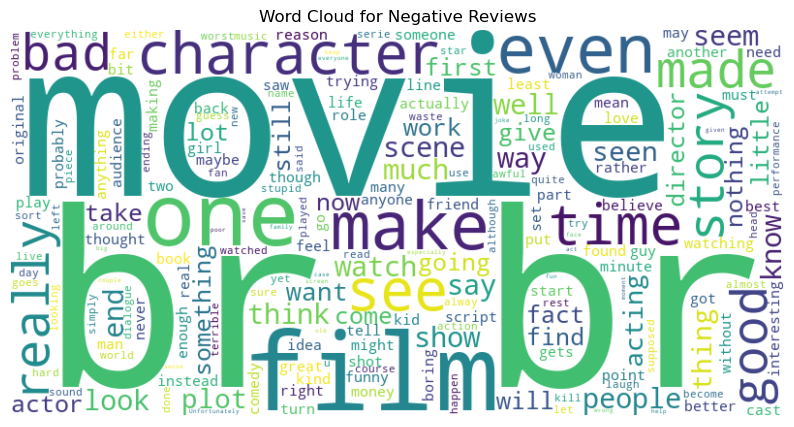

In [ ]:
negative_reviews = data[data['sentiment'] == 'negative']['review']
negative_text = ' '.join(negative_reviews)

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

In [15]:
def clean_html(text):
    soup = BeautifulSoup(text, "lxml")
    return soup.get_text()


In [16]:
data['review'] = data['review'].apply(clean_html)

<ipython-input-15-6e4353bba048>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "lxml")


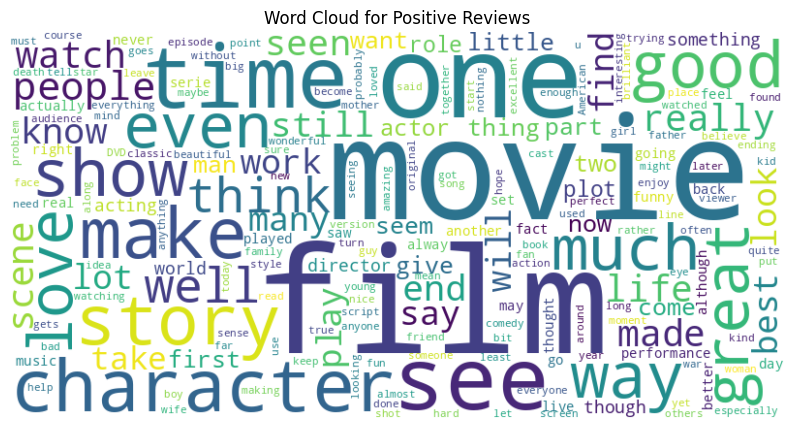

In [17]:
# Display a word cloud for positive reviews
from wordcloud import WordCloud

positive_reviews = data[data['sentiment'] == 'positive']['review']
positive_text = ' '.join(positive_reviews)

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

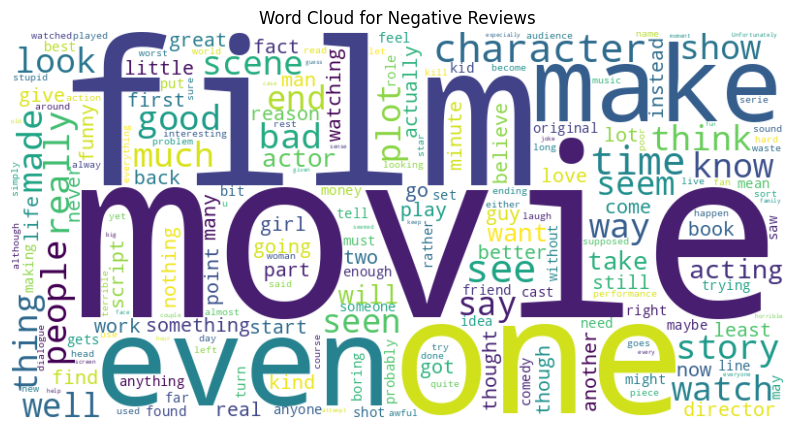

In [18]:
negative_reviews = data[data['sentiment'] == 'negative']['review']
negative_text = ' '.join(negative_reviews)

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

TEXT PREPROCESSING

In [19]:
# Download NLTK resources (only needed once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [20]:
# Initialize NLTK tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nlp = English()

In [21]:
# Function to preprocess text
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())

    # Remove stop words and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # Lemmatize (or use stemming if you prefer)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)


In [22]:
# Apply preprocessing to the 'review' column
data['cleaned_review'] = data['review'].apply(preprocess_text)

In [23]:
# Vectorization using TF-IDF (Term Frequency-Inverse Document Frequency)
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features based on your needs
X = vectorizer.fit_transform(data['cleaned_review'])

In [24]:
print(f'Shape of the feature matrix: {X.shape}')

Shape of the feature matrix: (50000, 5000)


In [25]:
data.head()

,review,sentiment,review_length,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,1761,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. The filming tec...,positive,998,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,926,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,748,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,petter mattei love time money visually stunnin...


MODEL TRAINING

In [26]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences in the dataset
def encode_data(texts, labels, max_len=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Convert labels to numeric format if they are not already
    if isinstance(labels.iloc[0], str):  # Use iloc for integer-based indexing
        label_map = {'negative': 0, 'positive': 1}
        labels = [label_map[label] for label in labels]

    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [27]:
# Split the dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['cleaned_review'], data['sentiment'], test_size=0.2, random_state=42
)

In [28]:
train_inputs, train_masks, train_labels = encode_data(train_texts, train_labels)
test_inputs, test_masks, test_labels = encode_data(test_texts, test_labels)

In [29]:
#creating dataloaders
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_loader = DataLoader(test_data, batch_size=16)


In [31]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [32]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_loader) * 4  # Assuming 4 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
def train_model(model, train_loader, optimizer, scheduler, epochs=4):
    model.train()
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        total_loss = 0
        for step, batch in enumerate(train_loader):
            batch_input_ids, batch_attention_masks, batch_labels = tuple(t.cuda() for t in batch)

            model.zero_grad()

            outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f'Average training loss: {avg_train_loss}')


In [37]:
train_model(model, train_loader, optimizer, scheduler)

Epoch 1/4
Average training loss: 0.3166851407557726
Epoch 2/4
Average training loss: 0.18056793834008275
Epoch 3/4
Average training loss: 0.08314282563752495
Epoch 4/4
Average training loss: 0.03682081677599344


In [45]:
def evaluate_model(model, test_loader, device='cpu'):
    model.to(device)  # Move model to the specified device
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            batch_input_ids, batch_attention_masks, batch_labels = batch

            # Move all inputs to the specified device
            batch_input_ids = batch_input_ids.to(device)
            batch_attention_masks = batch_attention_masks.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(
                input_ids=batch_input_ids,
                attention_mask=batch_attention_masks
            )

            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class
            all_labels.extend(batch_labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)

    print("Evaluation Metrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}\n")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    return accuracy, precision, recall, f1, roc_auc, all_labels, all_probs


In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(true_labels, all_probs):
    fpr, tpr, thresholds = roc_curve(true_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()


Evaluation Metrics:
Accuracy:  0.8935
Precision: 0.8890
Recall:    0.9012
F1 Score:  0.8950
ROC-AUC:   0.9583

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.89      0.89      4961
    Positive       0.89      0.90      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Confusion Matrix:
[[4394  567]
 [ 498 4541]]


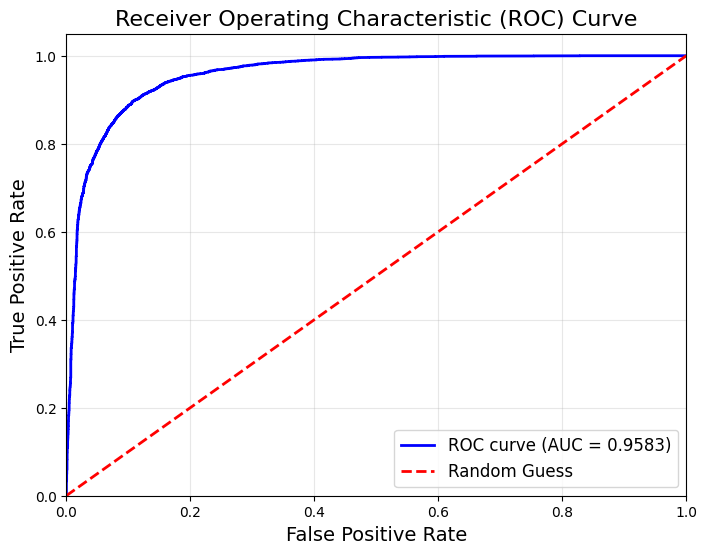

In [47]:
# Set device to CPU (or 'cuda' for GPU)
device = torch.device('cuda')

# Evaluate the model and get metrics
accuracy, precision, recall, f1, roc_auc, true_labels, all_probs = evaluate_model(model, test_loader, device)

# Plot ROC and AUC curves
plot_roc_auc(true_labels, all_probs)
